In [1]:
import pandas as pd
import numpy as np
import random
from transformers import ResNetModel
from torch import nn
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import v2
import torch

In [2]:
base_path = '../'
img_path = f'{base_path}Images/'
cap_path = f'{base_path}captions.txt'
data = pd.read_csv(cap_path)
data.head(n=10)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [4]:
# Select a random item from the data
item = data.sample(1)

# Print the image column of the selected item
item.image

# Reset the index of the selected item
item = item.reset_index(drop=True)

# Print the image and caption of the selected item
(item.image[0], item.caption[0])

('1819261140_6c022f4b1d.jpg',
 'A costumed figure leans into the dinner table .')

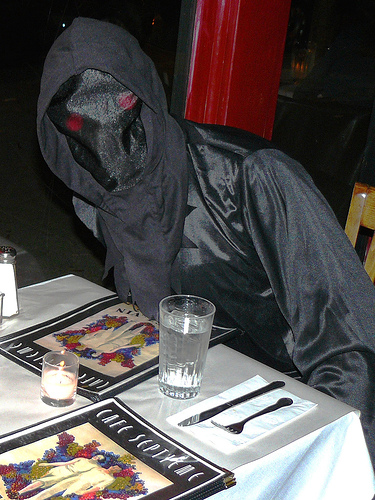

In [5]:
img = Image.open(f'{img_path}{item.image[0]}').convert('RGB')
img

In [6]:
partitions = np.load('flickr8k_partitions.npy', allow_pickle=True).item()

FileNotFoundError: [Errno 2] No such file or directory: 'flickr8k_partitions.npy'

In [33]:
chars = ['<SOS>', '<EOS>', '<PAD>', ' ', '!', '"', '#', '&', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
NUM_CHAR = len(chars)
idx2char = {k: v for k, v in enumerate(chars)}
char2idx = {v: k for k, v in enumerate(chars)}

In [34]:
TEXT_MAX_LEN = 201
DEVICE = 'cuda'

In [35]:
class Data(Dataset):
    def __init__(self, data, partition):
        self.data = data
        self.partition = partition
        self.num_captions = 5
        self.max_len = TEXT_MAX_LEN
        self.img_proc = torch.nn.Sequential(
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Resize((224, 224), antialias=True),
            v2.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),)

    def __len__(self):
        return len(self.partition)
    
    def __getitem__(self, idx):
        real_idx = self.num_captions*self.partition[idx]
        item = self.data.iloc[real_idx: real_idx+self.num_captions]
        ## image processing
        img_name = item.image.reset_index(drop=True)[0]
        img = Image.open(f'{img_path}{img_name}').convert('RGB')
        img = self.img_proc(img)
    
        ## caption processing
        caption = item.caption.reset_index(drop=True)[random.choice(list(range(self.num_captions)))]
        cap_list = list(caption)
        final_list = [chars[0]]
        final_list.extend(cap_list)
        final_list.extend([chars[1]])
        gap = self.max_len - len(final_list)
        final_list.extend([chars[2]]*gap)
        cap_idx = [char2idx[i] for i in final_list]
        return img, cap_idx

In [36]:
dataset = Data(data, partitions['train'])
img1, caption1 = next(iter(dataset))
img2, caption2 = next(iter(dataset))

In [37]:
img1.shape, img2.shape

(torch.Size([3, 224, 224]), torch.Size([3, 224, 224]))

In [38]:
caption1, caption2

([0,
  47,
  61,
  58,
  3,
  57,
  68,
  60,
  3,
  62,
  72,
  3,
  71,
  74,
  67,
  67,
  62,
  67,
  60,
  3,
  76,
  62,
  73,
  61,
  3,
  59,
  68,
  68,
  57,
  3,
  62,
  67,
  3,
  61,
  62,
  72,
  3,
  66,
  68,
  74,
  73,
  61,
  3,
  13,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
 